In [79]:
import numpy as np

import jax
import jax.numpy as jnp
from jax import jit, grad, vmap
import optax


import pickle as pkl

import itertools
import more_itertools as mit

import os

from alive_progress import alive_bar
import gc

import matplotlib.pyplot as plt

parallel_scan = jax.lax.associative_scan

### Dataset with 5 symbols, of 8-FSK with symbol duration of 1 sec and a samplingrate of 20 kHz

In [80]:
# generate dataset
sampling_rate = int(20e3)
duration = 5 
symbol_duration = 1
n_samples = sampling_rate * duration
symbol_samples = sampling_rate * symbol_duration
t = jnp.linspace(0, symbol_duration, symbol_samples, endpoint=False)
frequnecies = jnp.arange(0, 10e3, 1250)
relative_frequency_offset = 0.01
frequency_offset = relative_frequency_offset * frequnecies
samples = int(sampling_rate)
SNR = 15

# Chose five random frequencies
np.random.seed(0)
selected_symbols = np.random.randint(0, len(frequnecies)+1, 5)
print(selected_symbols)
def generate_five_signals(key, t, selected_symbols):
    signals = []
    for i in selected_symbols:
        print(f"Generating signal {i} with frequency {frequnecies[i]}")
        phase = 2 * jnp.pi * frequnecies[i] * t + jax.random.uniform(key) * 2 * jnp.pi
        if 0 < i < 9:
            signal = jnp.sqrt(2)*jnp.sin(phase)
        elif i == 0:
            signal = jnp.sin(phase)
        else:
            signal = jax.random.normal(key, shape=t.shape)
        signal = signal + jax.random.normal(key, shape=signal.shape) * jnp.sqrt(1/10**(SNR/10))
        signal = signal / jnp.sqrt(jnp.mean(signal**2))
        print(f"Power of signal {i}: {jnp.mean(signal**2)}")
        signals.append(signal)
        key, _ = jax.random.split(key)
    return jnp.array(signals).flatten()

key = jax.random.PRNGKey(1)
signals = generate_five_signals(key, t, selected_symbols)

[5 0 3 3 7]
Generating signal 5 with frequency 6250.0
Power of signal 5: 0.9999998807907104
Generating signal 0 with frequency 0.0
Power of signal 0: 1.0000001192092896
Generating signal 3 with frequency 3750.0
Power of signal 3: 1.0000001192092896
Generating signal 3 with frequency 3750.0
Power of signal 3: 1.0000001192092896
Generating signal 7 with frequency 8750.0
Power of signal 7: 1.0


In [81]:
signals.shape

(100000,)

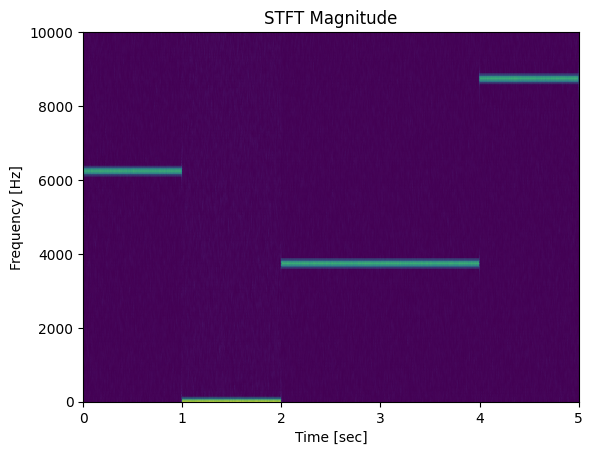

In [82]:
from scipy.signal import stft

# Calculate the stft of the waveform
f, k, Zxx = stft(signals, fs=sampling_rate, nperseg=256)
plt.pcolormesh(k, f, jnp.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [83]:
def binary_operator_diag(element_i, element_j):
    a_i, bu_i = element_i
    a_j, bu_j = element_j

    return a_j * a_i, a_j * bu_i + bu_j


def init_lru_parameters(N, H, r_min = 0.0, r_max = 1, max_phase = 6.28):
    # N: state dimension, H: model dimension
    # Initialization of Lambda is complex valued distributed uniformly on ring
    # between r_min and r_max, with phase in [0, max_phase].

    u1 = np.random.uniform(size = (N,))
    u2 = np.random.uniform(size = (N,))

    nu_log = np.log(-0.5*np.log(u1*(r_max**2-r_min**2) + r_min**2))
    theta_log = np.log(max_phase*u2)

    # Glorot initialized Input/Output projection matrices
    B_re = np.random.normal(size=(N,H))/np.sqrt(2*H)
    B_im = np.random.normal(size=(N,H))/np.sqrt(2*H)
    C_re = np.random.normal(size=(H,N))/np.sqrt(N)
    C_im = np.random.normal(size=(H,N))/np.sqrt(N)
    D = np.random.normal(size=(H,))

    # Normalization
    diag_lambda = np.exp(-np.exp(nu_log) + 1j*np.exp(theta_log))
    gamma_log = np.log(np.sqrt(1-np.abs(diag_lambda)**2))

    return nu_log, theta_log, B_re, B_im, C_re, C_im, D, gamma_log


def forward_LRU(lru_parameters, input_sequence):
    # Unpack the LRU parameters
    nu_log, theta_log, B_re, B_im, C_re, C_im, D, gamma_log = lru_parameters

    # Initialize the hidden state
    Lambda = jnp.exp(-jnp.exp(nu_log) + 1j*jnp.exp(theta_log))
    B_norm = (B_re + 1j*B_im) * jnp.expand_dims(jnp.exp(gamma_log), axis=-1)
    #print(B_norm.shape)
    C = C_re + 1j*C_im

    Lambda_elements = jnp.repeat(Lambda[None, ...], input_sequence.shape[0], axis=0)

    Bu_elements = jax.vmap(lambda u: B_norm @ u)(input_sequence)
    elements = (Lambda_elements, Bu_elements)
    _, inner_states = parallel_scan(binary_operator_diag, elements) # all x_k
    y = jax.vmap(lambda x, u: (C @ x).real + D * u)(inner_states, input_sequence)


    return y

In [84]:
def init_mlp_parameters(layers):
    # Initialize the MLP parameters
    parameters = []
    for i in range(len(layers)-1):
        W = np.random.normal(size=(layers[i], layers[i+1]))/np.sqrt(layers[i])
        b = np.zeros((layers[i+1],))
        parameters.append((W, b))

    return parameters

@jit
def forward_mlp(mlp_parameters, input, activation_function = jnp.tanh):
    # Forward pass of the MLP
    
    x = input

    for W, b in mlp_parameters:
        x = x @ W + b
        x = activation_function(x)

    return x

def forward_mlp_linear_with_classification(mlp_parameters, input, activation_function = jnp.tanh):
    
    x = input

    # Only apply the MLP up to the second last layer
    for W, b in mlp_parameters[:-1]:
        x = x @ W + b
        x = activation_function(x)

    # Apply the last layer without activation function
    W, b = mlp_parameters[-1]
    x = x @ W + b

    # Use the softmax function on the last layer
    x = jax.nn.softmax(x)


    return x

def layer_normalization(activations):
    mu  = jnp.mean(activations)
    sigma = jnp.std(activations)
    return (activations - mu) / sigma

layer_normalization_sequence = vmap(layer_normalization)

def max_pooling(sequence_to_pool):
    return jnp.max(sequence_to_pool, axis=0)

def mean_pooling(sequence_to_pool):
    return jnp.mean(sequence_to_pool, axis=0)

def sum_pooling(sequence_to_pool):
    return jnp.sum(sequence_to_pool, axis=0)

In [85]:
def model_forward(input_sequence, parameters):
    Linear_encoder_parameter,  LRU, seconday_parameters, Linear_decoder_parameter = parameters

    x = forward_mlp(Linear_encoder_parameter, input_sequence)
    skip = x
    x = layer_normalization_sequence(x)
    x = forward_LRU(LRU, x)
    x = forward_mlp(seconday_parameters, x) + skip
    x = max_pooling(x)
    x = forward_mlp_linear_with_classification(Linear_decoder_parameter, x)

    return x

# Batch model forward
batch_model_forward = vmap(model_forward, in_axes=(0, None))

def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)

@jit
def loss_fn(input_sequences, target_sequences, parameters):
    y = batch_model_forward(input_sequences, parameters)

    # Binary cross entropy loss
    return -jnp.mean(jnp.sum(target_sequences * jnp.log(y), axis=1))

@jit
def model_grad(input_sequence, target_sequence, parameters):
    return grad(loss_fn, argnums=2)(input_sequence, target_sequence, parameters)

@jit
def parameter_update(parameters, gradients, learning_rate = 0.01):
    new_parameters = []
    im = []
    for parameter, gradient in zip(parameters[0], gradients[0]):
        im.append((parameter[0] - learning_rate * gradient[0], parameter[1] - learning_rate * gradient[1]))

    new_parameters.append(im)

    im = []
    for parameter, gradient in zip(parameters[1], gradients[1]):
        im.append(parameter - learning_rate * gradient)    

    new_parameters.append(im)

    im = []
    for parameter, gradient in zip(parameters[2], gradients[2]):
        im.append((parameter[0] - learning_rate * gradient[0], parameter[1] - learning_rate * gradient[1]))

    new_parameters.append(im)

    im = []
    for parameter, gradient in zip(parameters[3], gradients[3]):
        im.append((parameter[0] - learning_rate * gradient[0], parameter[1] - learning_rate * gradient[1]))

    new_parameters.append(im)

    return new_parameters


@jit
def accuracy(input_sequences, target_sequences, parameters):
    y = batch_model_forward(input_sequences, parameters)
    return jnp.mean(jnp.argmax(y, axis=1) == jnp.argmax(target_sequences, axis=1))

batch_model_grad = vmap(model_grad, in_axes=(0, 0, None))

In [86]:
# Load model
with open('model_parameters.pkl', 'rb') as f:
    model_parameters = pkl.load(f)

model_parameters

{'Untrained': [[(array([[ 1.27823153, -0.42819644, -1.33519863,  0.36506289, -0.31110208]]),
    array([0., 0., 0., 0., 0.])),
   (array([[ 2.82711457e-01,  9.09702920e-02,  7.52326674e-02,
            -8.91150596e-01,  2.58069386e-01, -1.29860815e-01,
             1.46520124e-01,  2.33246898e-01, -9.47462152e-02,
             5.29764584e-01],
           [ 3.96867511e-01, -3.48267521e-01,  1.14560275e-01,
            -3.48131673e-01, -4.76111782e-01,  1.31457940e-01,
            -5.40633600e-01,  4.34251285e-04, -2.89606741e-01,
             6.48518577e-01],
           [ 3.02816675e-01, -4.64511359e-01, -1.10518664e+00,
             4.09889838e-01,  3.19704861e-01, -5.44139472e-01,
            -3.07210813e-01,  3.11898631e-01,  9.42900444e-01,
            -9.99449067e-01],
           [ 8.48548367e-02, -3.66312386e-01,  4.58042101e-01,
            -4.52702795e-01,  1.71493909e-01, -4.67593042e-01,
             1.56375062e-01, -4.86650439e-01,  1.04703457e+00,
             1.25015039e-01

In [87]:
selected_symbols = np.array([9,9,5,9,9])
signals = generate_five_signals(key, t, selected_symbols).reshape(n_samples,1)

Generating signal 9 with frequency 8750.0
Power of signal 9: 1.0000001192092896
Generating signal 9 with frequency 8750.0
Power of signal 9: 0.9999998807907104
Generating signal 5 with frequency 6250.0
Power of signal 5: 1.0
Generating signal 9 with frequency 8750.0
Power of signal 9: 0.9999998807907104
Generating signal 9 with frequency 8750.0
Power of signal 9: 1.0


In [88]:
results = []
interval = []
for x in range(0, len(signals)-19000, 1000):
    input_sequence = signals[x:x+20000]

    print(model_forward(input_sequence, model_parameters["Epoch 4"]))
    results.append(model_forward(input_sequence, model_parameters["Epoch 4"]))
    interval.append(x)
    print(x, x+20000)

[3.0454649e-02 3.8456451e-04 2.8479442e-03 7.2068069e-04 3.2098780e-03
 2.2636356e-03 3.2073413e-03 6.7441505e-03 9.5016706e-01]
0 20000
[2.5502475e-02 3.7830134e-04 2.8153078e-03 7.1524648e-04 3.0278643e-03
 2.1506338e-03 2.8499218e-03 6.5497863e-03 9.5601052e-01]
1000 21000
[2.5371516e-02 3.6802323e-04 2.7637829e-03 7.1028364e-04 3.0334177e-03
 2.1334374e-03 2.8809290e-03 6.6058803e-03 9.5613265e-01]
2000 22000
[2.5371535e-02 3.6802370e-04 2.7637852e-03 7.1028358e-04 3.0334203e-03
 2.1334384e-03 2.8809288e-03 6.6058827e-03 9.5613259e-01]
3000 23000
[2.7798962e-02 3.4338931e-04 2.6029528e-03 7.2309212e-04 2.9370342e-03
 2.1966784e-03 3.2292053e-03 6.8128593e-03 9.5335591e-01]
4000 24000
[2.7798934e-02 3.4338882e-04 2.6029490e-03 7.2309136e-04 2.9370312e-03
 2.1966784e-03 3.2292036e-03 6.8128495e-03 9.5335591e-01]
5000 25000
[2.5816681e-02 2.9932923e-04 2.2870458e-03 7.8890700e-04 2.4858434e-03
 2.0369710e-03 3.4614753e-03 7.4302168e-03 9.5539361e-01]
6000 26000
[2.5816668e-02 2.993292

Generating signal 9 with frequency 8750.0
Power of signal 9: 1.0000001192092896
Generating signal 9 with frequency 8750.0
Power of signal 9: 0.9999998807907104
Generating signal 5 with frequency 6250.0
Power of signal 5: 1.0
Generating signal 9 with frequency 8750.0
Power of signal 9: 0.9999998807907104
Generating signal 9 with frequency 8750.0
Power of signal 9: 1.0


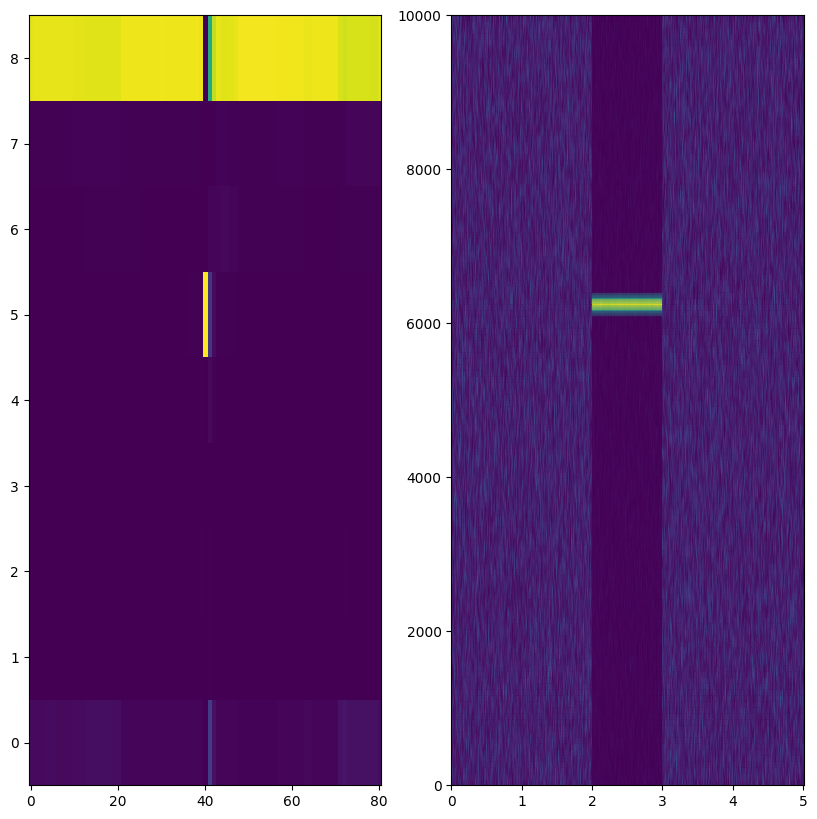

In [89]:
# Make a heatmap of the results
results = jnp.array(results)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,2,1)

ax.imshow(results.T, aspect='auto')
ax.invert_yaxis()
ax2 = fig.add_subplot(1,2,2)
from scipy.signal import stft

# Calculate the stft of the waveform
f, k, Zxx = stft(generate_five_signals(key, t, selected_symbols), fs=sampling_rate, nperseg=256)
ax2.pcolormesh(k, f, jnp.abs(Zxx), shading='gouraud')

# Testing even more symbols and the transition between sybmols

In [90]:
super_restults = []
for k in range(10):
    selected_symbols= np.random.randint(0, 10, 10)
    signals = generate_five_signals(key, t, selected_symbols).reshape(selected_symbols.shape[0]*symbol_samples,1)

    results = []
    interval = []
    for x in range(0, len(signals)-19000, 1000):
        input_sequence = signals[x:x+20000]

        print(model_forward(input_sequence, model_parameters["Epoch 4"]))
        results.append(model_forward(input_sequence, model_parameters["Epoch 4"]))
        interval.append(x)
        print(x, x+20000)

    super_restults.append((results, selected_symbols))

    # # Make a heatmap of the results
    # results = jnp.array(results)

    # fig = plt.figure(figsize=(10,10))
    # ax = fig.add_subplot(1,2,1)

    # ax.imshow(results.T, aspect='auto')
    # ax.invert_yaxis()
    # ax2 = fig.add_subplot(1,2,2)
    # from scipy.signal import stft

    # # Calculate the stft of the waveform
    # f, k, Zxx = stft(generate_five_signals(key, t, selected_symbols), fs=sampling_rate, nperseg=256)
    # ax2.pcolormesh(k, f, jnp.abs(Zxx), shading='gouraud')

Generating signal 9 with frequency 8750.0
Power of signal 9: 1.0000001192092896
Generating signal 3 with frequency 3750.0
Power of signal 3: 0.9999998807907104
Generating signal 5 with frequency 6250.0
Power of signal 5: 1.0
Generating signal 2 with frequency 2500.0
Power of signal 2: 0.9999998807907104
Generating signal 4 with frequency 5000.0
Power of signal 4: 0.9999997615814209
Generating signal 7 with frequency 8750.0
Power of signal 7: 1.000000238418579
Generating signal 6 with frequency 7500.0
Power of signal 6: 1.0000001192092896
Generating signal 8 with frequency 8750.0
Power of signal 8: 1.000000238418579
Generating signal 8 with frequency 8750.0
Power of signal 8: 1.0
Generating signal 1 with frequency 1250.0
Power of signal 1: 1.0
[3.0454649e-02 3.8456451e-04 2.8479442e-03 7.2068069e-04 3.2098780e-03
 2.2636356e-03 3.2073413e-03 6.7441505e-03 9.5016706e-01]
0 20000
[1.6069761e-02 2.8572194e-04 2.2368345e-03 7.3447410e-04 2.1515971e-03
 1.9067257e-03 2.4779532e-03 6.3754730e

In [91]:
print(super_restults[0][0][40], super_restults[0][1])

im = []

a = []

for k in range(len(super_restults)):
    b = []
    for i in range(len(interval)):
        relative_offset = 1-np.abs((interval[i] % 20000-10000) /10000)
        out = (np.argmax(super_restults[k][0][i]), np.max(super_restults[k][0][i]))
        im.append((out, relative_offset))
        if out[0] < 8:
            print(f"Symbol {out} with relative offset {relative_offset}, true symbol {super_restults[k][1][i//20:i//20+2] if relative_offset > 0 else super_restults[k][1][i//20]}")
            b.append((k,i,out, relative_offset, super_restults[k][1][i//20:i//20+2] if relative_offset > 0 else super_restults[k][1][i//20]))
    a.append(b)        


[1.2488532e-03 2.8089348e-03 1.3899839e-05 3.7922774e-04 9.8193658e-04
 9.9099004e-01 2.2377127e-03 1.5419570e-06 1.3378358e-03] [9 3 5 2 4 7 6 8 8 1]
Symbol (Array(3, dtype=int32), Array(0.9931972, dtype=float32)) with relative offset 0.0, true symbol 3
Symbol (Array(3, dtype=int32), Array(0.90393704, dtype=float32)) with relative offset 0.09999999999999998, true symbol [3 5]
Symbol (Array(3, dtype=int32), Array(0.89024806, dtype=float32)) with relative offset 0.19999999999999996, true symbol [3 5]
Symbol (Array(3, dtype=int32), Array(0.88365865, dtype=float32)) with relative offset 0.30000000000000004, true symbol [3 5]
Symbol (Array(3, dtype=int32), Array(0.8822203, dtype=float32)) with relative offset 0.4, true symbol [3 5]
Symbol (Array(3, dtype=int32), Array(0.8822203, dtype=float32)) with relative offset 0.5, true symbol [3 5]
Symbol (Array(3, dtype=int32), Array(0.88006073, dtype=float32)) with relative offset 0.6, true symbol [3 5]
Symbol (Array(3, dtype=int32), Array(0.887977

In [92]:
coutnt_corret_positives = 0
for _ in a:
    for x in _:
        if type(x[4]) != np.ndarray:
                coutnt_corret_positives += 1

coutnt_corret_positives

print(f"Amount of positive correct detections {coutnt_corret_positives/len(im)}")

# Count the amount of transitions and where they end up
transitions = np.zeros(10)
for k in a:
    for x in k:
         if type(x[4]) == np.ndarray:
                transitions[x[4][1]] += 1
                print(x)
print(f"Transitions count for each end point {transitions}")

Amount of positive correct detections 0.04806629834254143
(0, 21, (Array(3, dtype=int32), Array(0.90393704, dtype=float32)), 0.09999999999999998, array([3, 5]))
(0, 22, (Array(3, dtype=int32), Array(0.89024806, dtype=float32)), 0.19999999999999996, array([3, 5]))
(0, 23, (Array(3, dtype=int32), Array(0.88365865, dtype=float32)), 0.30000000000000004, array([3, 5]))
(0, 24, (Array(3, dtype=int32), Array(0.8822203, dtype=float32)), 0.4, array([3, 5]))
(0, 25, (Array(3, dtype=int32), Array(0.8822203, dtype=float32)), 0.5, array([3, 5]))
(0, 26, (Array(3, dtype=int32), Array(0.88006073, dtype=float32)), 0.6, array([3, 5]))
(0, 27, (Array(3, dtype=int32), Array(0.8879774, dtype=float32)), 0.7, array([3, 5]))
(0, 28, (Array(3, dtype=int32), Array(0.88797766, dtype=float32)), 0.8, array([3, 5]))
(0, 29, (Array(3, dtype=int32), Array(0.8879775, dtype=float32)), 0.9, array([3, 5]))
(0, 30, (Array(3, dtype=int32), Array(0.8879568, dtype=float32)), 1.0, array([3, 5]))
(0, 31, (Array(3, dtype=int32

In [93]:
# Count the amount of transitions and where they end up, excluding the same symbol
transitions2 = np.zeros(10)
for k in a:
    for x in k:
         if type(x[4]) == np.ndarray:
            if x[4][0] != x[4][1]:
                transitions2[x[4][1]] += 1
                print(x)
print(f"Transitions count for each end point {transitions2}")

(0, 21, (Array(3, dtype=int32), Array(0.90393704, dtype=float32)), 0.09999999999999998, array([3, 5]))
(0, 22, (Array(3, dtype=int32), Array(0.89024806, dtype=float32)), 0.19999999999999996, array([3, 5]))
(0, 23, (Array(3, dtype=int32), Array(0.88365865, dtype=float32)), 0.30000000000000004, array([3, 5]))
(0, 24, (Array(3, dtype=int32), Array(0.8822203, dtype=float32)), 0.4, array([3, 5]))
(0, 25, (Array(3, dtype=int32), Array(0.8822203, dtype=float32)), 0.5, array([3, 5]))
(0, 26, (Array(3, dtype=int32), Array(0.88006073, dtype=float32)), 0.6, array([3, 5]))
(0, 27, (Array(3, dtype=int32), Array(0.8879774, dtype=float32)), 0.7, array([3, 5]))
(0, 28, (Array(3, dtype=int32), Array(0.88797766, dtype=float32)), 0.8, array([3, 5]))
(0, 29, (Array(3, dtype=int32), Array(0.8879775, dtype=float32)), 0.9, array([3, 5]))
(0, 30, (Array(3, dtype=int32), Array(0.8879568, dtype=float32)), 1.0, array([3, 5]))
(0, 31, (Array(3, dtype=int32), Array(0.890036, dtype=float32)), 0.9, array([3, 5]))
(0

In [94]:
print(f"Print the values when aligned {[]}")

Print the values when aligned []


In [120]:
aligned_guess_and_values = []
for idk, k in enumerate(a):
    for idx, x in enumerate(k):
        if type(x[4]) != np.ndarray:
            aligned_guess_and_values.append((x[2][0], x[4], (idk, idx)))
# Percentage of correct guesses
print(f"When perfectly alligned {np.mean([x[0] == x[1] for x in aligned_guess_and_values])}")

# Print the values of the wrong guess
print(f"When perfectly alligned and the guess is wrong {[ x[2] if x[0] != x[1]  else 1 for x in aligned_guess_and_values]}")
a[7][102]


When perfectly alligned 0.9080459770114943
When perfectly alligned and the guess is wrong [1, 1, 1, 1, 1, 1, (0, 105), (0, 125), 1, 1, 1, 1, (1, 60), 1, 1, (1, 82), 1, 1, 1, 1, 1, 1, 1, 1, (2, 102), 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, (5, 0), 1, 1, 1, (5, 63), 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, (7, 102), 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


(7, 140, (Array(7, dtype=int32), Array(0.99344254, dtype=float32)), 0.0, 8)

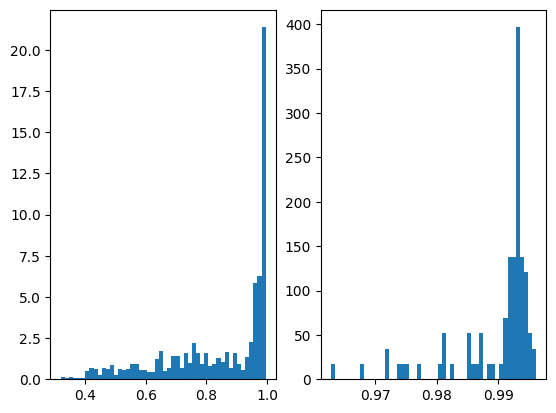

Percentage of values above 0.9 0.1645813282001925


In [78]:
values_when_relative_offset_about_zero = []
values_when_relative_offset_are_zero = []
for k in a:
    for x in k:
        if x[3] > 0:
            values_when_relative_offset_about_zero.append(x[2][1])
        else:
            values_when_relative_offset_are_zero.append(x[2][1])

values_when_relative_offset_about_zero = np.array(values_when_relative_offset_about_zero)

fig, ax = plt.subplots(1,2)
ax[0].hist(values_when_relative_offset_about_zero, bins=50, density=True)
ax[1].hist(values_when_relative_offset_are_zero, bins=50, density=True)
plt.show()
print(f"Percentage of values above 0.9 {np.sum(values_when_relative_offset_about_zero > 0.99)/len(values_when_relative_offset_about_zero)}")

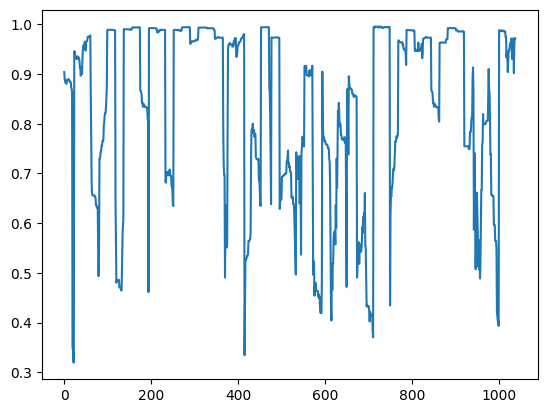

In [24]:
plt.plot(values_when_relative_offset_about_zero)

(array([ 2.89129412,  1.92752941,  0.96376471,  1.92752941,  0.96376471,
         1.92752941,  1.92758965,  2.89129412,  3.85505882,  0.96376471,
         0.        ,  0.        ,  0.        ,  0.96376471,  0.96376471,
         1.92752941,  2.89129412,  7.71011765,  3.8551793 ,  0.        ,
         1.92752941,  0.        ,  0.96376471,  2.89129412, 14.45647059,
         4.81882353,  4.81882353,  2.89129412,  2.89129412,  4.81882353,
         6.74635294, 10.60174307, 10.60141176, 25.05788235, 11.56517647,
         6.74635294,  7.71011765, 16.384     , 50.11576471,  6.74635294,
         1.92752941,  0.96376471,  0.96376471,  0.96379482, 22.16658824,
        27.94917647, 66.49976471, 12.52894118, 87.70258824, 71.31858824]),
 array([0.90013283, 0.90204018, 0.90394753, 0.90585488, 0.90776223,
        0.90966958, 0.91157693, 0.91348422, 0.91539156, 0.91729891,
        0.91920626, 0.92111361, 0.92302096, 0.92492831, 0.92683566,
        0.928743  , 0.93065035, 0.9325577 , 0.93446505, 0.936372

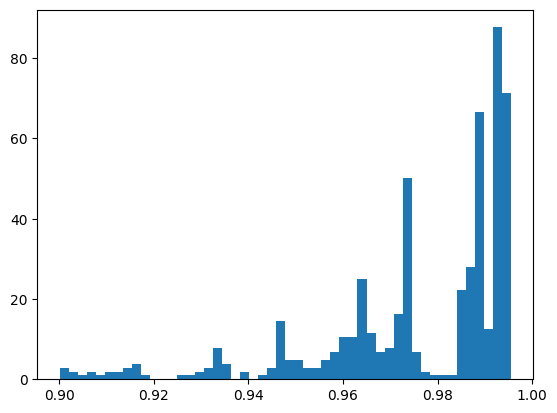

In [28]:
# Only include values between 0.9 and 1
values_when_relative_offset_about_zero_09_1 = values_when_relative_offset_about_zero[values_when_relative_offset_about_zero > 0.9]

plt.hist(values_when_relative_offset_about_zero_09_1, bins=50, density=True)

In [ ]:
np.subtract(transitions, transitions2)

array([19.,  0., 19., 19.,  0.,  0., 19., 19., 76.,  0.])

### Testing different SNR, without altering model

In [72]:
import time
# generate dataset
sampling_rate = int(20e3)
symbol_duration = 1
symbol_samples = sampling_rate * symbol_duration
t = jnp.linspace(0, symbol_duration, symbol_samples, endpoint=False)
frequnecies = jnp.arange(0, 10e3, 1250)
relative_frequency_offset = 0.01
frequency_offset = relative_frequency_offset * frequnecies
SNR = np.array([5, 10, 15, 20, 25])

# Funtion to make waveform
def generate_symbols(selected_symbols, SNR):
    key = jax.random.PRNGKey(time.time_ns())
    signal = []
    for idx, i in enumerate(selected_symbols):
        #print(f"Generating signal {i} with frequency {frequnecies[i]}")
        phase = 2 * jnp.pi * frequnecies[i] * t + jax.random.uniform(key) * 2 * jnp.pi
        if 0 < i < 9:
            im_signal = jnp.sqrt(2)*jnp.sin(phase)
        elif i == 0:
            im_signal = jnp.sin(phase)
        else:
            im_signal = jax.random.normal(key, shape=t.shape)
        im_signal = im_signal + jax.random.normal(key, shape=im_signal.shape) * jnp.sqrt(1/10**(SNR/10))
        signal.append( im_signal / jnp.sqrt(jnp.mean(im_signal**2)))
        #print(f"Power of signal {i}: {jnp.mean(signal**2)}")
        selected_symbols[idx] = i
        key, _ = jax.random.split(key)

    return jnp.array(selected_symbols), jnp.array(signal).flatten()



In [76]:
#Test all five different SNR level

SNR_test_results = {}

for snr in SNR:
    number_of_symbols = 1000
    symbol_sequences = np.array(np.random.randint(0, 10, number_of_symbols))

    symbol_sequences_freq, waveform_sequence = generate_symbols(symbol_sequences, snr)

    waveform_sequence= waveform_sequence.reshape(len(waveform_sequence), 1)

    results = []
    for x in range(0, waveform_sequence.shape[0]-19000, 1000):
        #print("k")
        input_sequence = waveform_sequence[x:x+20000]
        results.append(model_forward(input_sequence, model_parameters["Epoch 4"]))

    SNR_test_results[f"SNR {snr}"] = (results, symbol_sequences)
    

KeyboardInterrupt: 

In [45]:
SNR_test_results["SNR 5"]

([],
 array([8, 3, 2, 1, 1, 8, 6, 1, 0, 0, 3, 8, 6, 2, 8, 1, 8, 2, 9, 7, 8, 9,
        0, 1, 1, 1, 2, 8, 7, 6, 1, 8, 1, 7, 4, 8, 8, 4, 0, 7, 9, 2, 0, 6,
        8, 5, 7, 9, 3, 5, 0, 3, 0, 8, 4, 8, 3, 0, 9, 6, 3, 3, 0, 6, 5, 2,
        5, 1, 1, 8, 9, 4, 0, 9, 8, 4, 7, 5, 7, 4, 3, 1, 9, 1, 8, 0, 6, 5,
        6, 0, 4, 6, 4, 1, 0, 9, 4, 3, 9, 8, 3, 7, 7, 3, 2, 4, 7, 7, 9, 6,
        9, 7, 9, 1, 0, 1, 9, 8, 9, 8, 1, 7, 4, 1, 8, 0, 2, 6, 4, 5, 6, 0,
        6, 9, 4, 7, 1, 8, 5, 8, 5, 5, 0, 7, 8, 5, 0, 7, 8, 6, 0, 0, 9, 4,
        5, 4, 1, 3, 4, 6, 9, 9, 0, 4, 1, 1, 1, 9, 6, 6, 1, 3, 3, 6, 4, 4,
        1, 4, 3, 5, 4, 0, 1, 1, 1, 7, 8, 2, 5, 2, 3, 0, 7, 3, 9, 4, 1, 6,
        4, 6, 1, 8, 1, 0, 2, 1, 8, 5, 9, 5, 8, 8, 1, 5, 0, 5, 0, 3, 6, 5,
        0, 5, 4, 2, 8, 5, 3, 9, 7, 0, 0, 2, 5, 3, 3, 2, 1, 2, 2, 3, 2, 4,
        5, 3, 1, 2, 3, 8, 9, 3, 1, 7, 1, 0, 1, 8, 2, 0, 6, 4, 9, 1, 7, 3,
        1, 3, 9, 3, 2, 7, 3, 1, 3, 8, 3, 6, 4, 7, 5, 7, 2, 2, 1, 3, 9, 2,
        5, 7, 0, 6, 6, 1, 0, 9, 6